# MoA Feature Engineering

## 1. Preparation

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy 
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir='../input/lish-moa/'
os.listdir(data_dir)

['train_targets_scored.csv',
 'sample_submission.csv',
 'train_drug.csv',
 'train_targets_nonscored.csv',
 'train_features.csv',
 'test_features.csv']

In [4]:
# load data
train_features = pd.read_csv(data_dir + 'train_features.csv')
train_targets_scored = pd.read_csv(data_dir + 'train_targets_scored.csv')
train_targets_nonscored = pd.read_csv(data_dir + 'train_targets_nonscored.csv')
train_drug = pd.read_csv(data_dir + 'train_drug.csv')
test_features = pd.read_csv(data_dir + 'test_features.csv')
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')

print('train_features: {}'.format(train_features.shape))
print('train_targets_scored: {}'.format(train_targets_scored.shape))
print('train_targets_nonscored: {}'.format(train_targets_nonscored.shape))
print('train_drug: {}'.format(train_drug.shape))
print('test_features: {}'.format(test_features.shape))
print('sample_submission: {}'.format(sample_submission.shape))

train_features: (23814, 876)
train_targets_scored: (23814, 207)
train_targets_nonscored: (23814, 403)
train_drug: (23814, 2)
test_features: (3982, 876)
sample_submission: (3982, 207)


In [5]:
# copy features

train_features2=train_features.copy()
test_features2=test_features.copy()

In [6]:
# gene and cell features
GENES=[col for col in train_features.columns if col.startswith('g-')]
CELLS=[col for col in train_features.columns if col.startswith('c-')]
print(len(GENES))
print(len(CELLS))

772
100


## 2. Feature Engineering



**QuantileTransformer**

As shown in **Mechanisms of Action (MoA) Prediction Part I - Preparation and EDA**, many of the numerical features and highly skewed and non-standard. It's natural to use **quantile transformer** to transform the data and force them to follow a specific distribution. Also, quantile transformer is a robust scaling method commonly used in many competitions.

In [7]:
from sklearn.preprocessing import QuantileTransformer

qt=QuantileTransformer(n_quantiles=100,
                       random_state=42,
                       output_distribution='normal')      # gaussian distribution

data = pd.concat([pd.DataFrame(train_features[GENES+CELLS]), 
                  pd.DataFrame(test_features[GENES+CELLS])])


data2=qt.fit_transform(data[GENES+CELLS])     # no data leakage

train_features[GENES+CELLS]=pd.DataFrame(data2[:train_features.shape[0]])
test_features[GENES+CELLS]=pd.DataFrame(data2[-test_features.shape[0]:])

In [7]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.146806,0.902075,-0.418339,-0.961202,-0.254770,-1.021300,...,0.405455,0.362189,1.296097,0.830281,-0.242026,1.015974,-0.506553,0.311033,0.537989,0.644894
1,id_000779bfc,trt_cp,72,D1,0.128824,0.676862,0.274345,0.090495,1.208863,0.688965,...,-0.527074,1.127076,0.716060,0.047538,0.410130,0.741295,0.200866,0.175029,0.914180,1.163177
2,id_000a6266a,trt_cp,48,D1,0.790372,0.939951,1.428097,-0.121817,-0.002067,1.495091,...,-0.834469,-0.747431,0.952950,0.046551,-1.221419,-0.391112,-0.763788,-0.282154,-1.132628,1.086688
3,id_0015fd391,trt_cp,48,D1,-0.729866,-0.277163,-0.441200,0.766612,2.347817,-0.862761,...,-1.429097,-0.762287,-1.653318,-1.259768,-0.949084,-1.235487,-1.327725,-0.983066,-0.489388,-0.921288
4,id_001626bd3,trt_cp,72,D2,-0.444558,-0.481202,0.974729,0.977467,1.468304,-0.874772,...,0.013943,0.000436,1.049064,1.677765,0.792976,-0.374676,0.144687,0.422382,-0.479788,1.118644


take a look at feature distributions once again

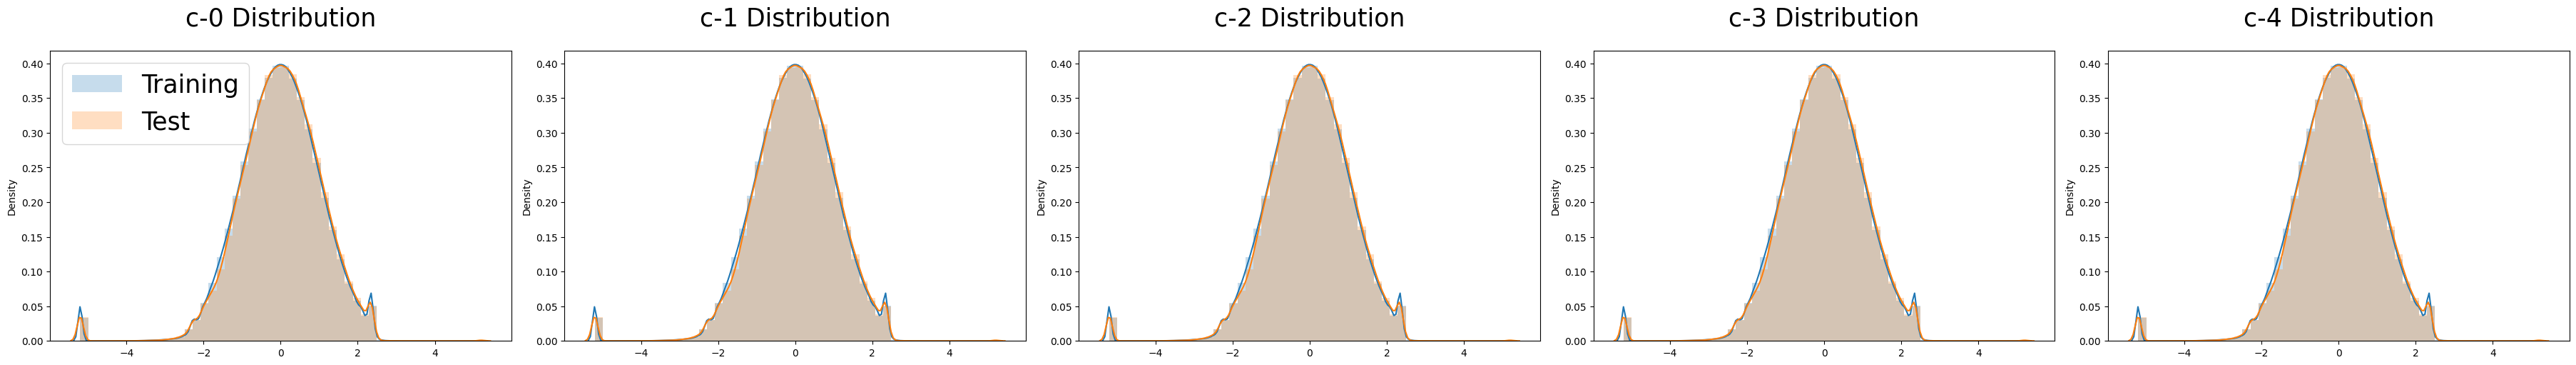

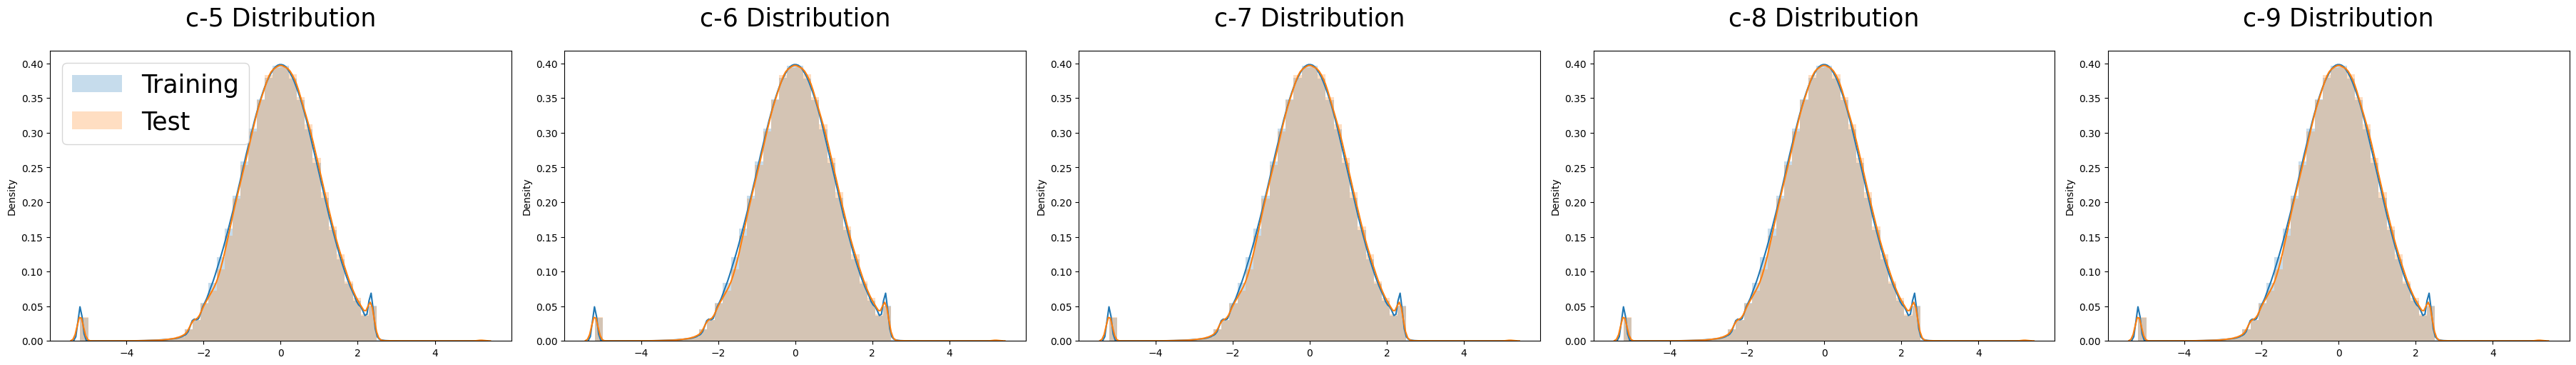

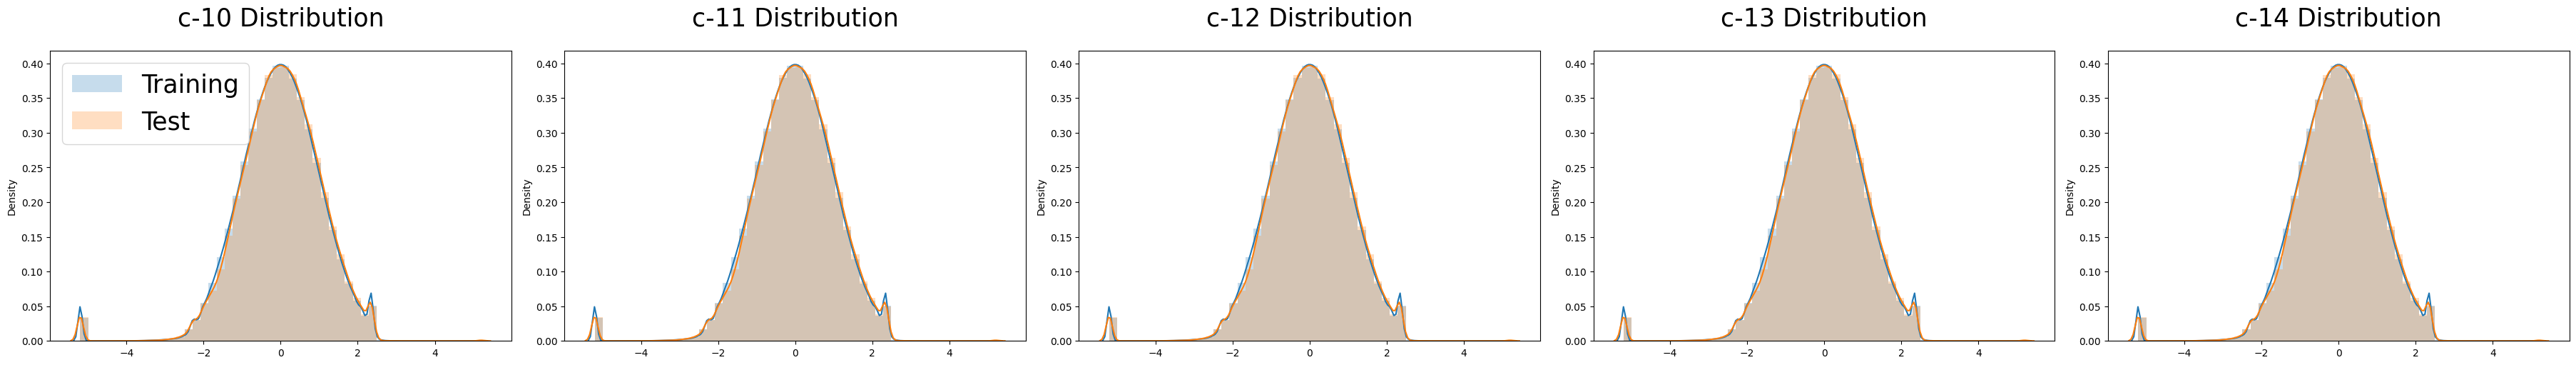

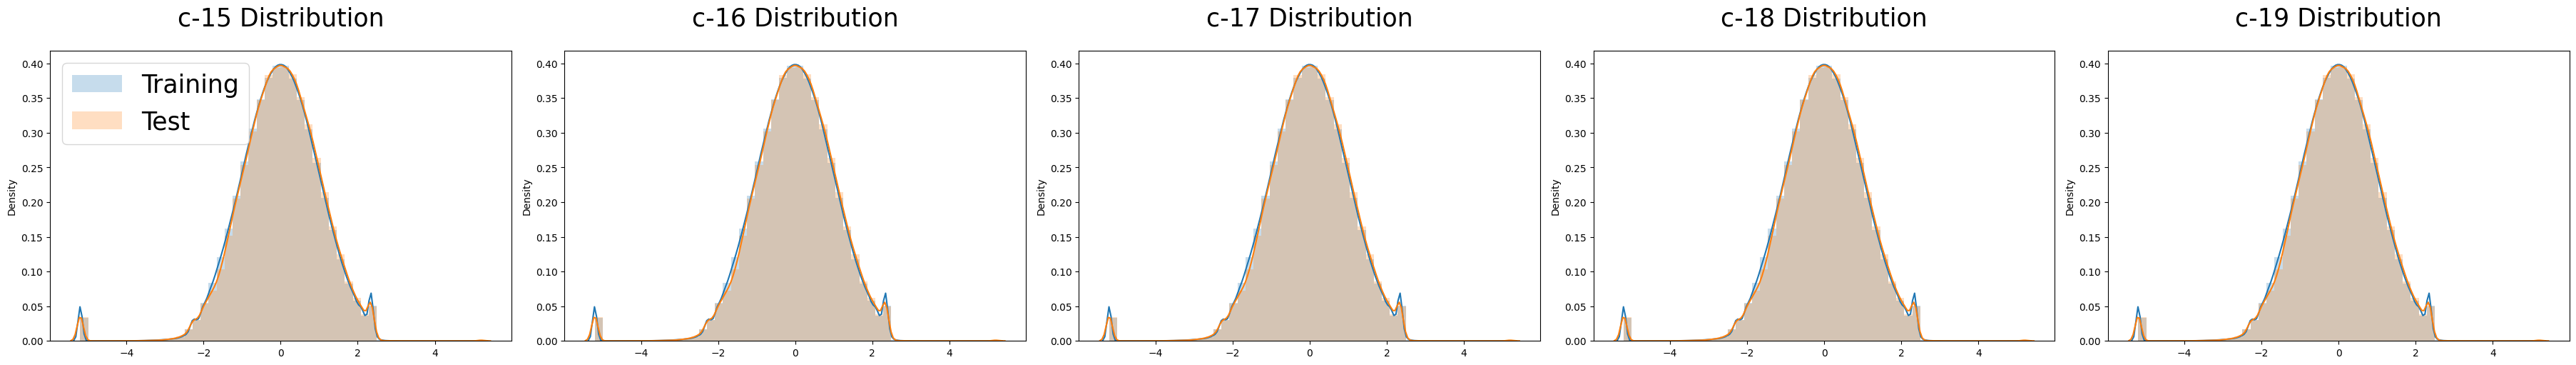

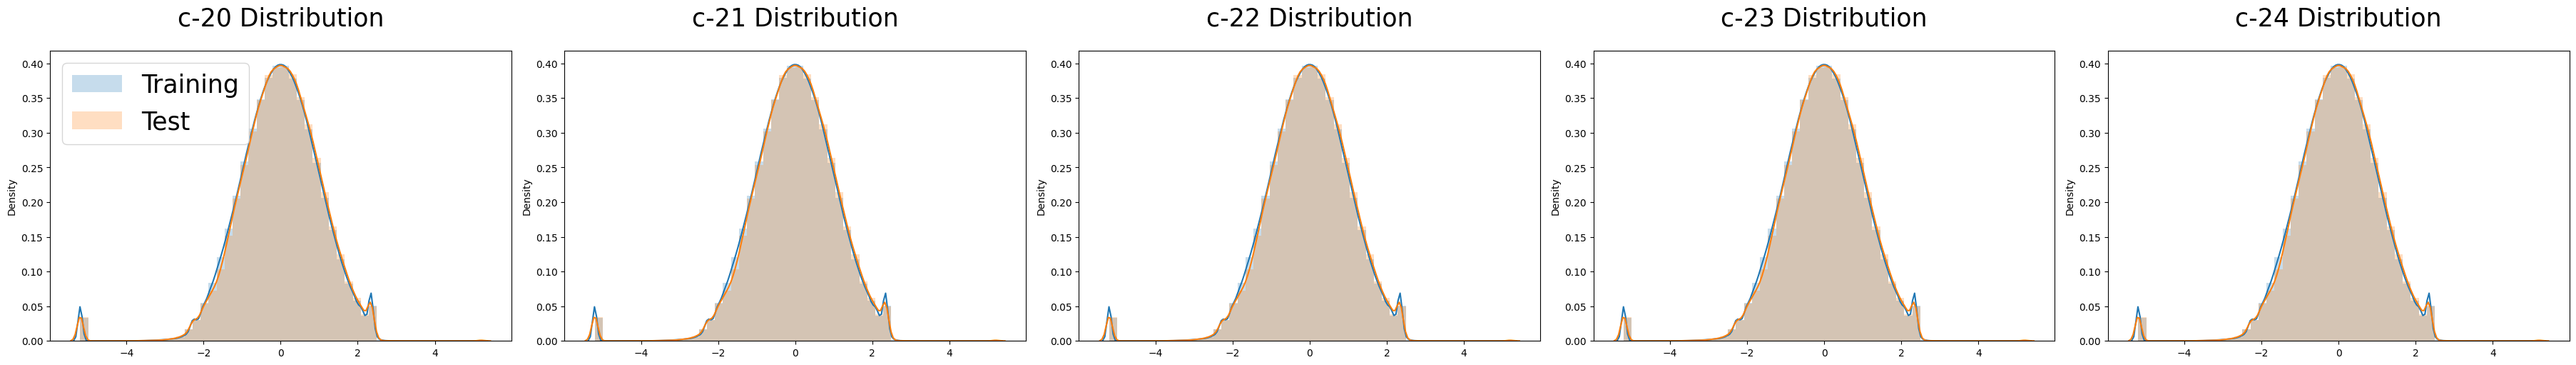

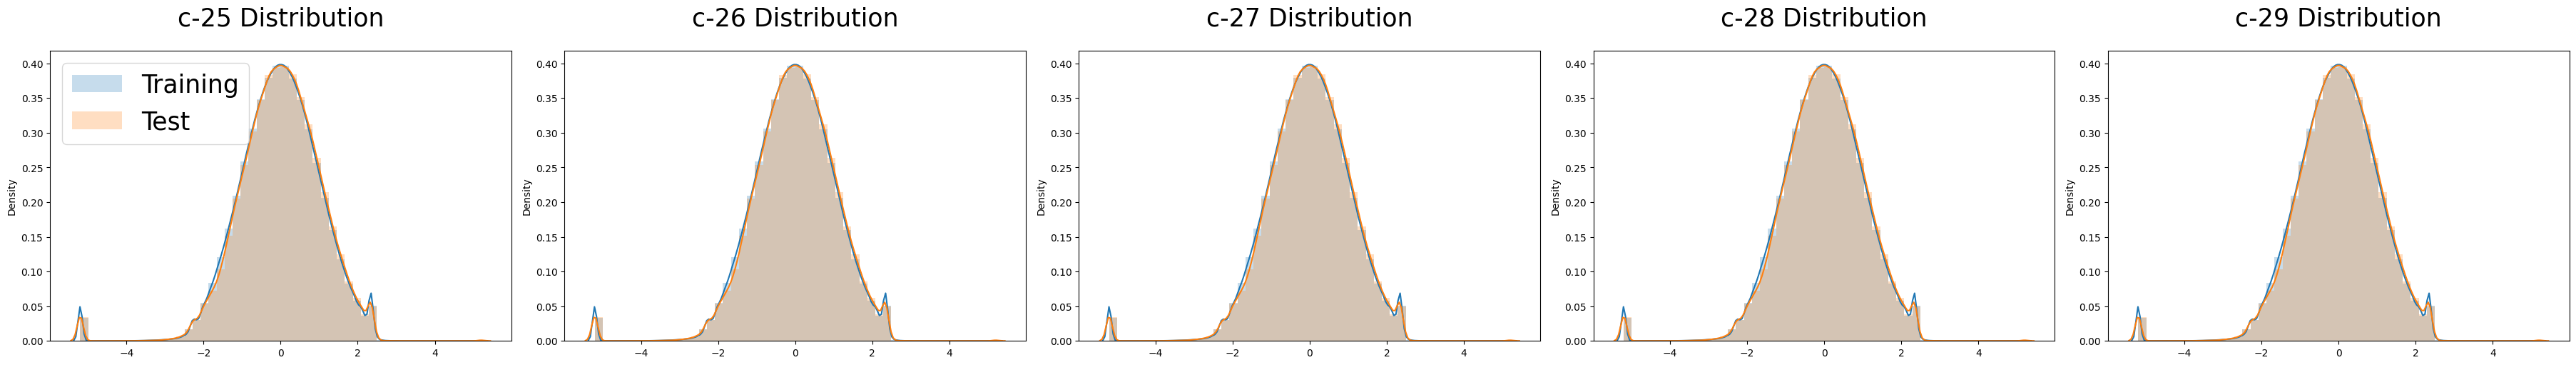

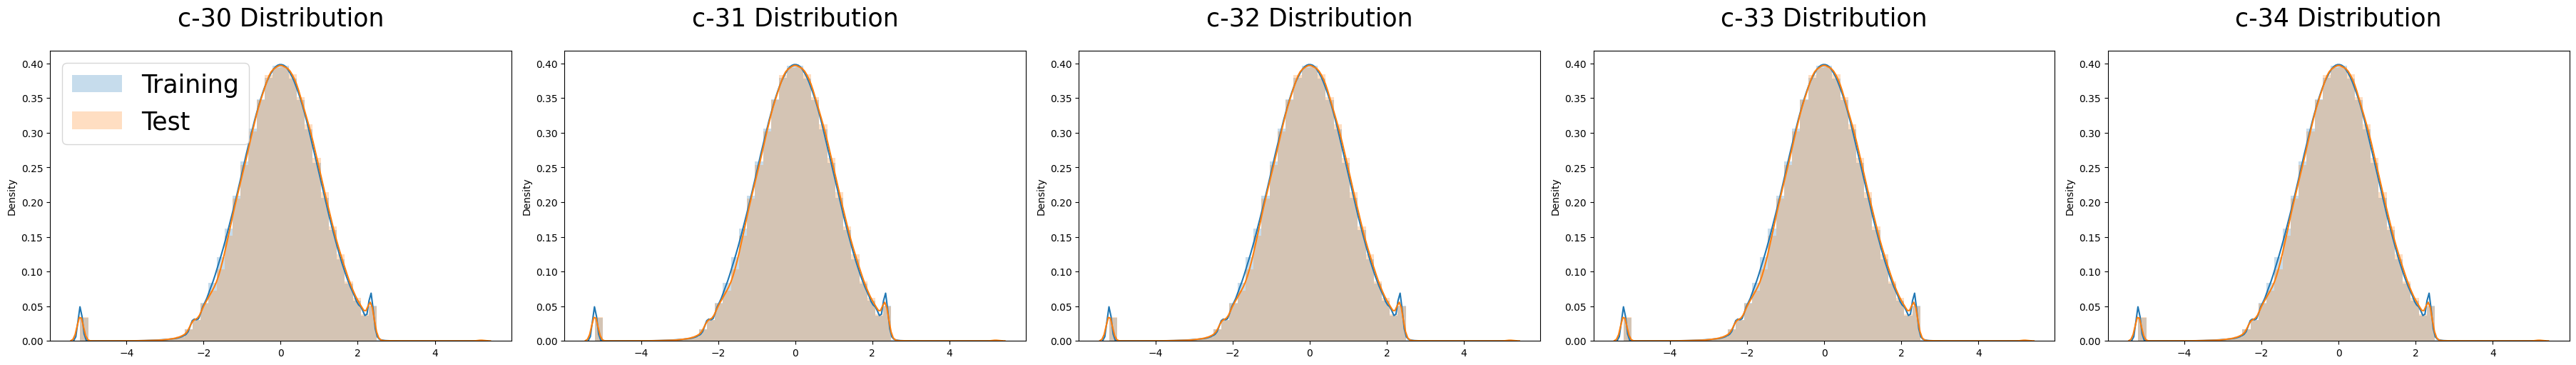

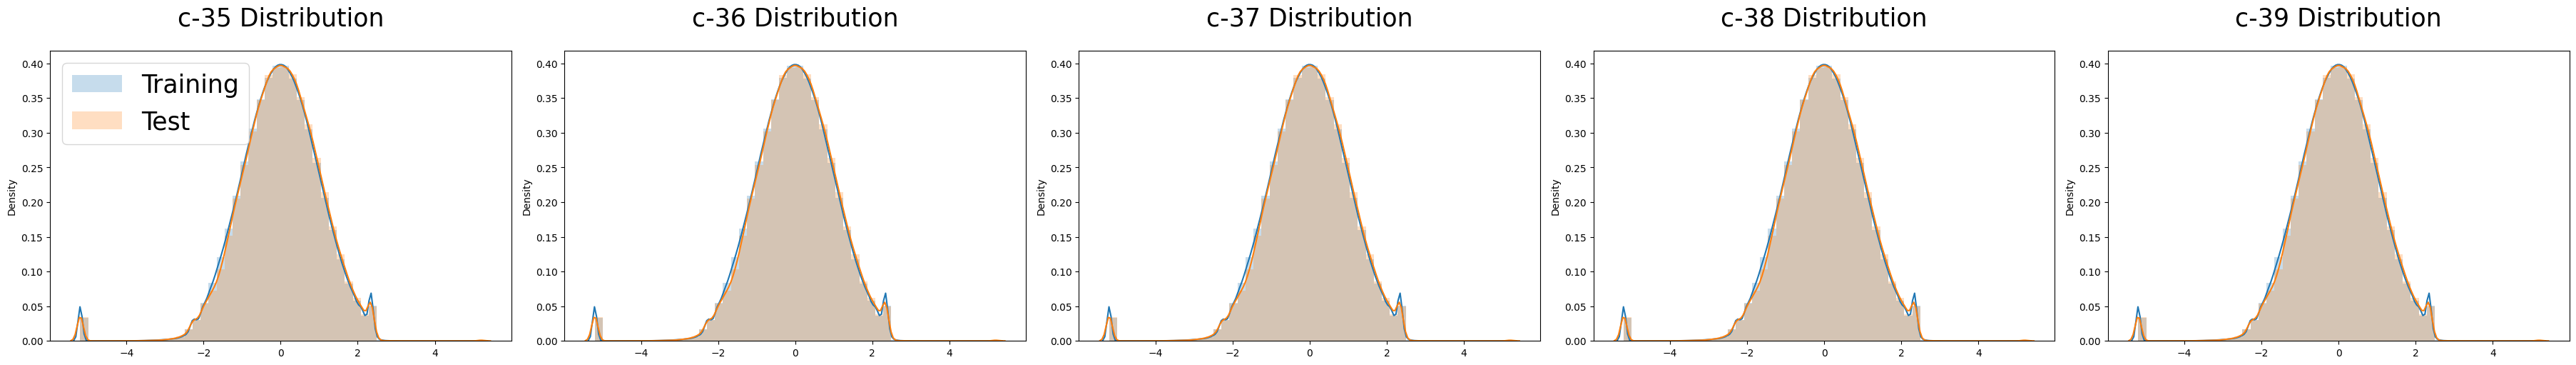

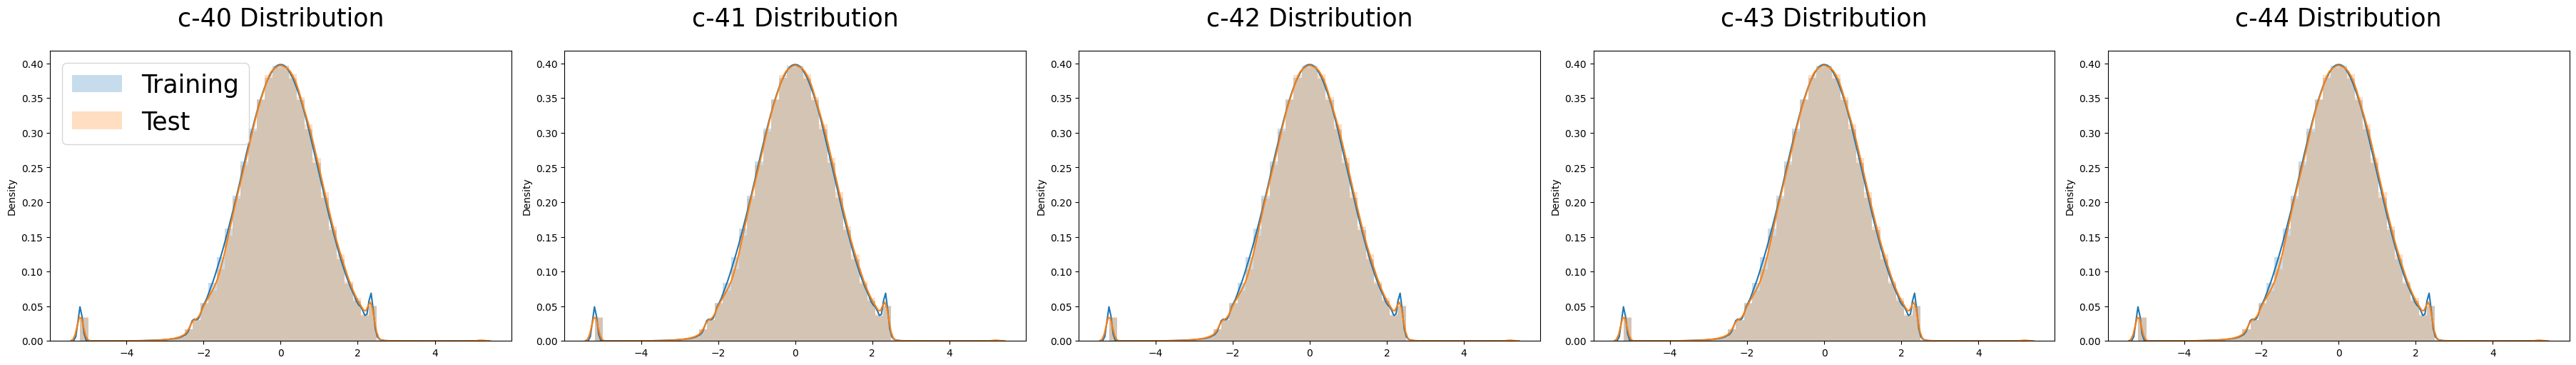

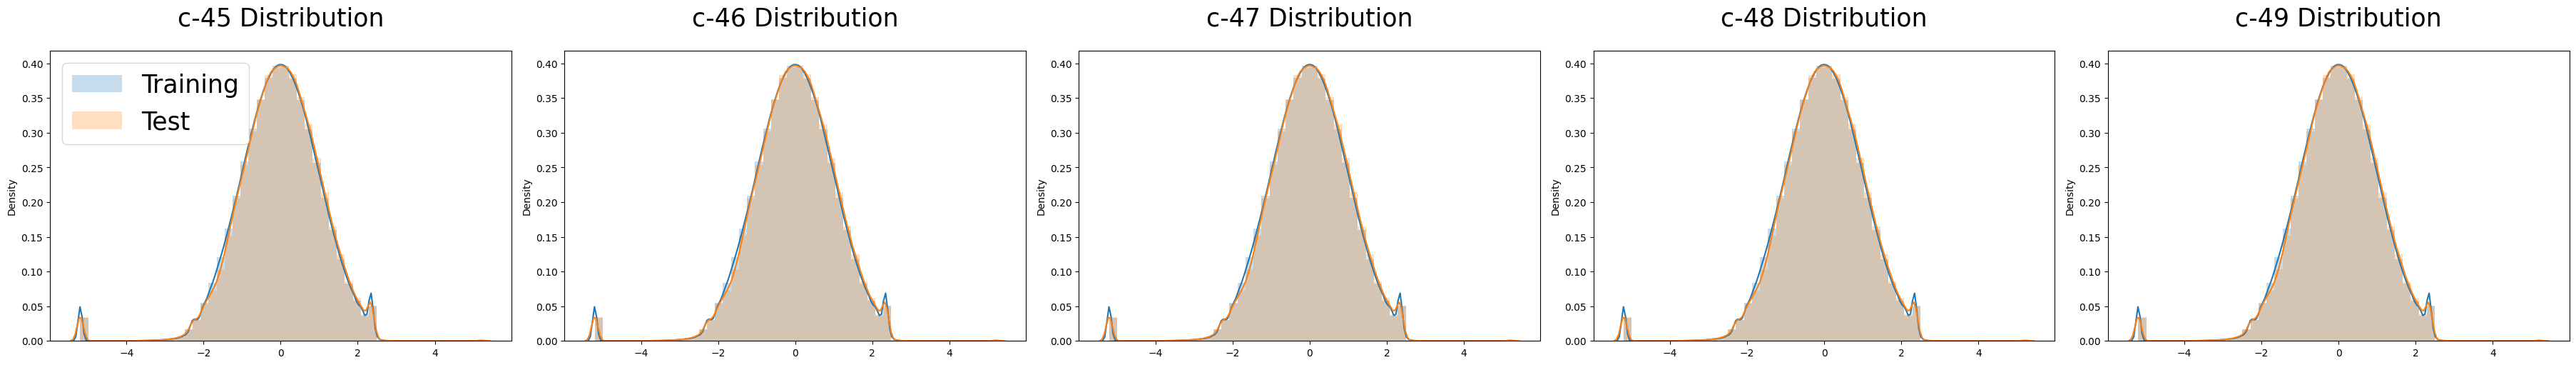

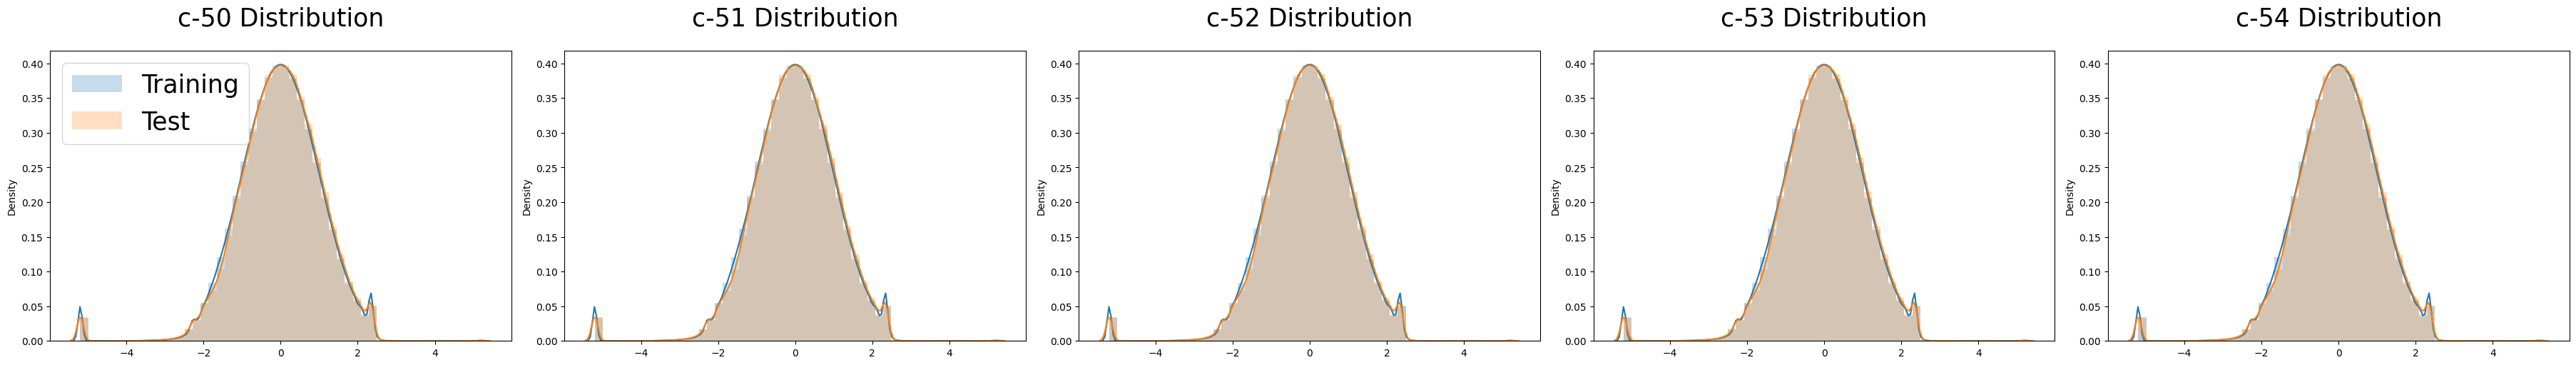

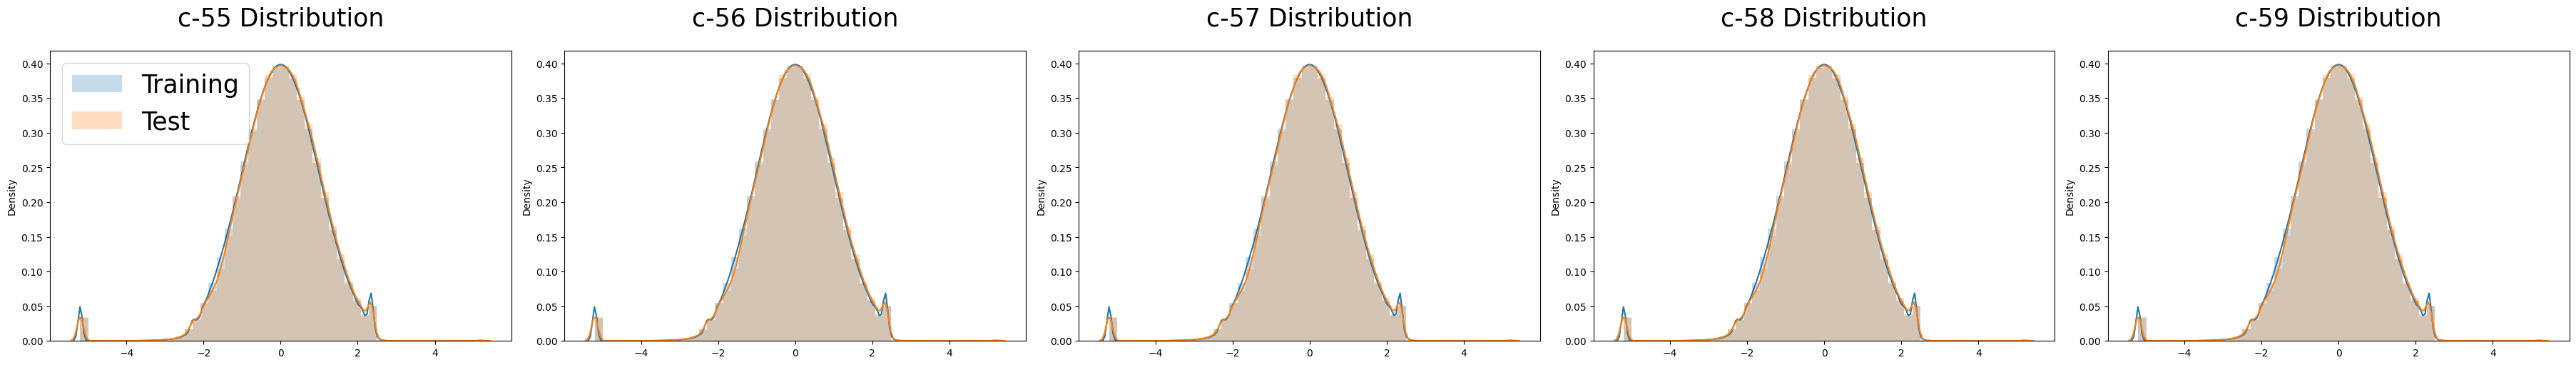

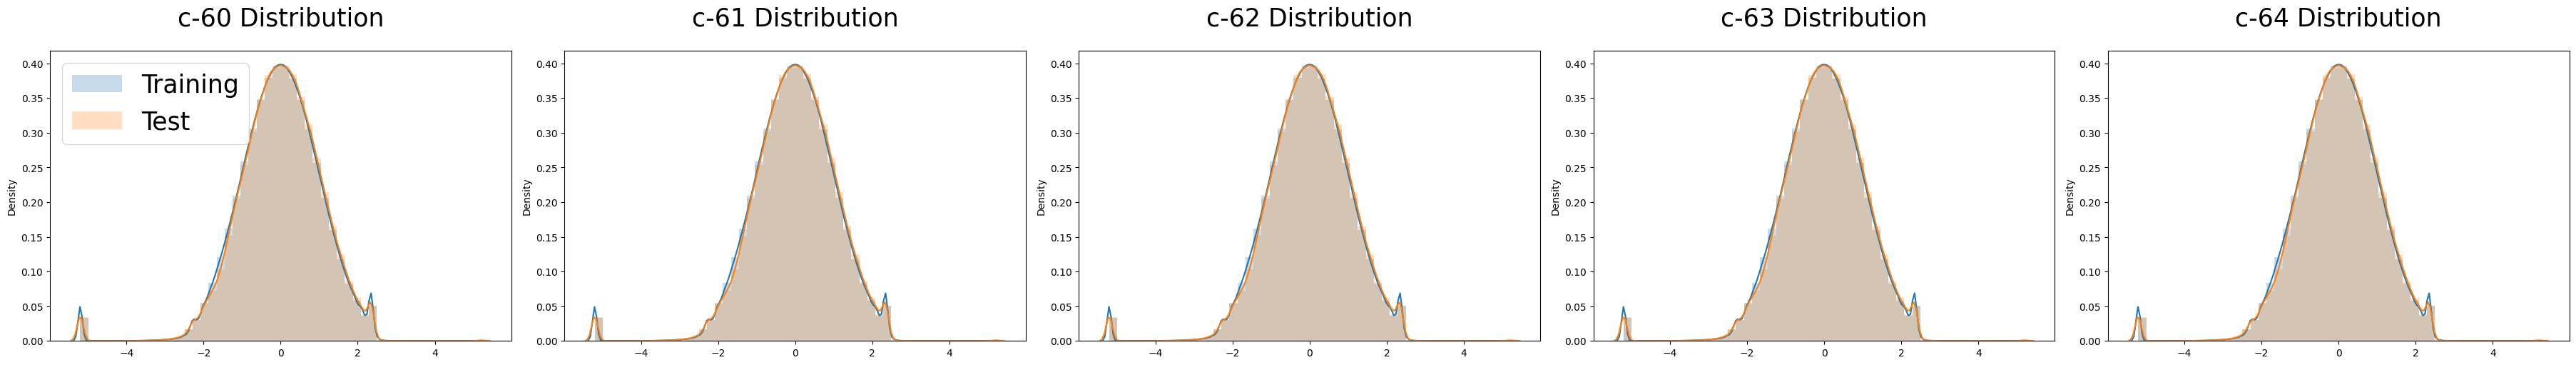

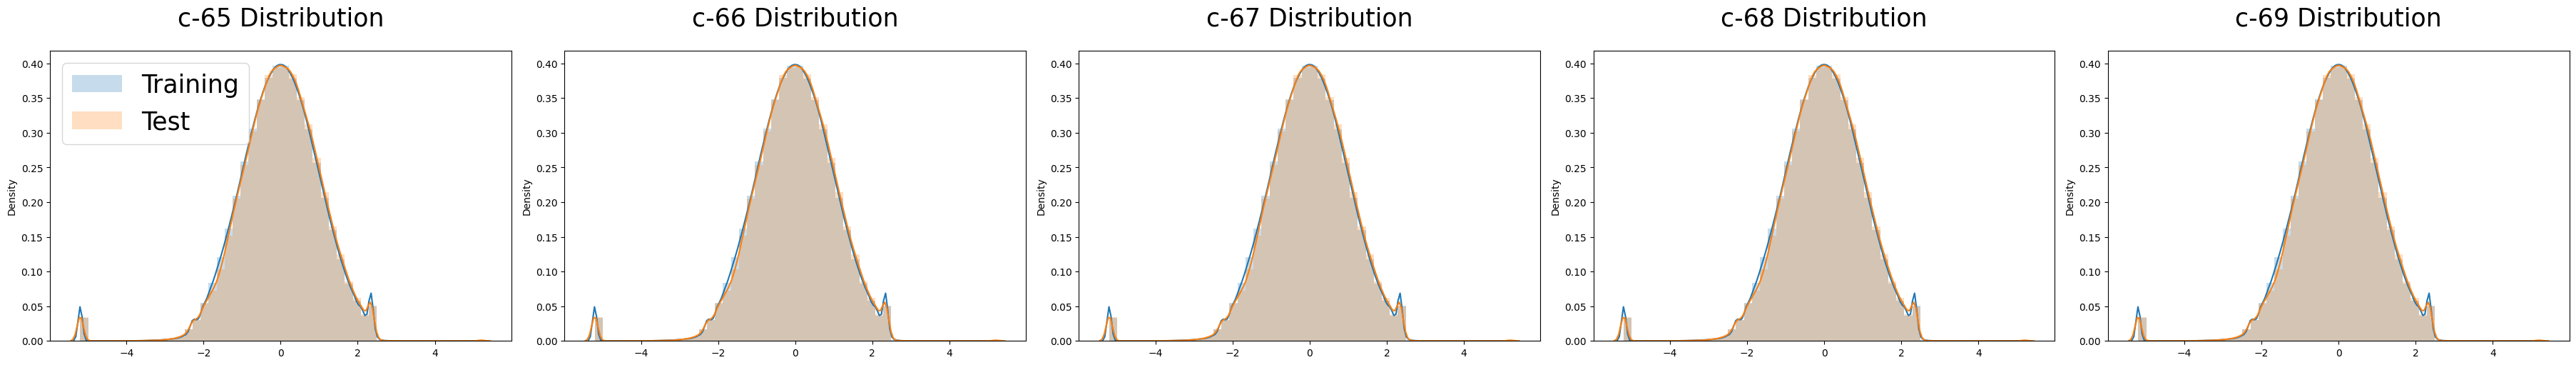

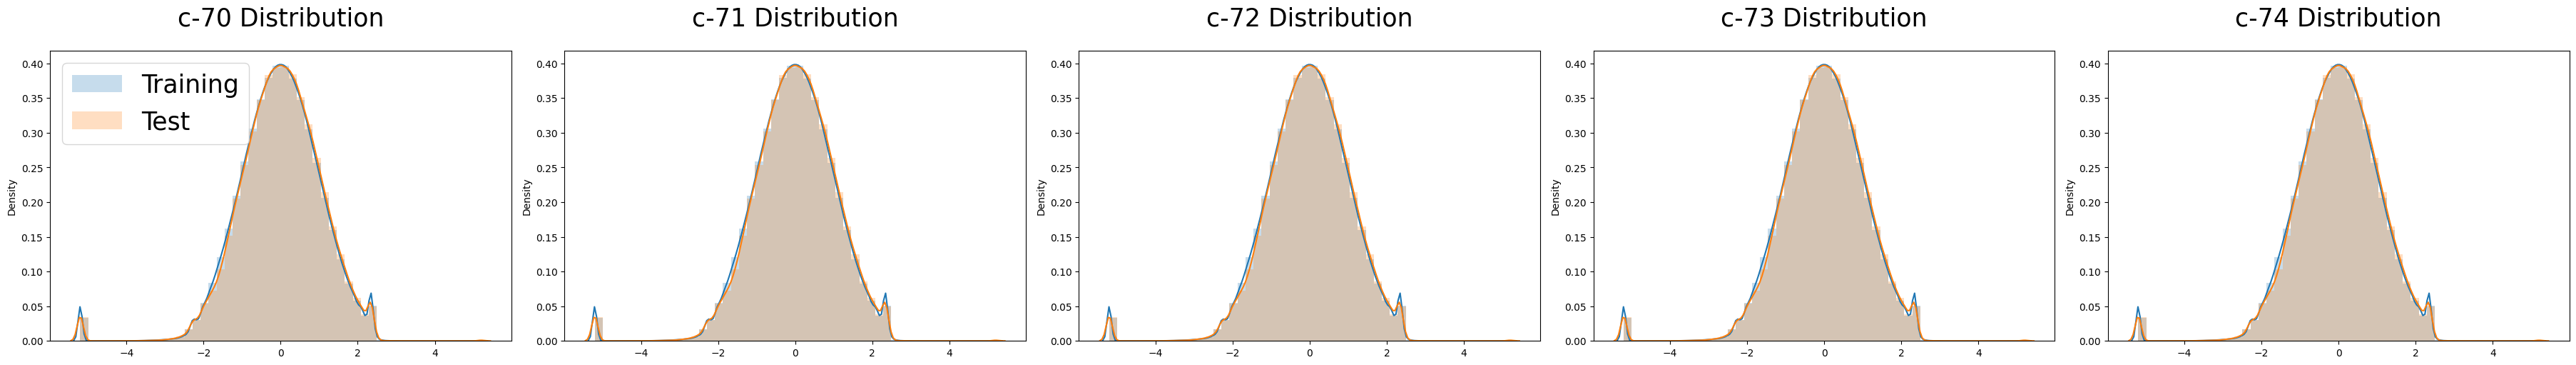

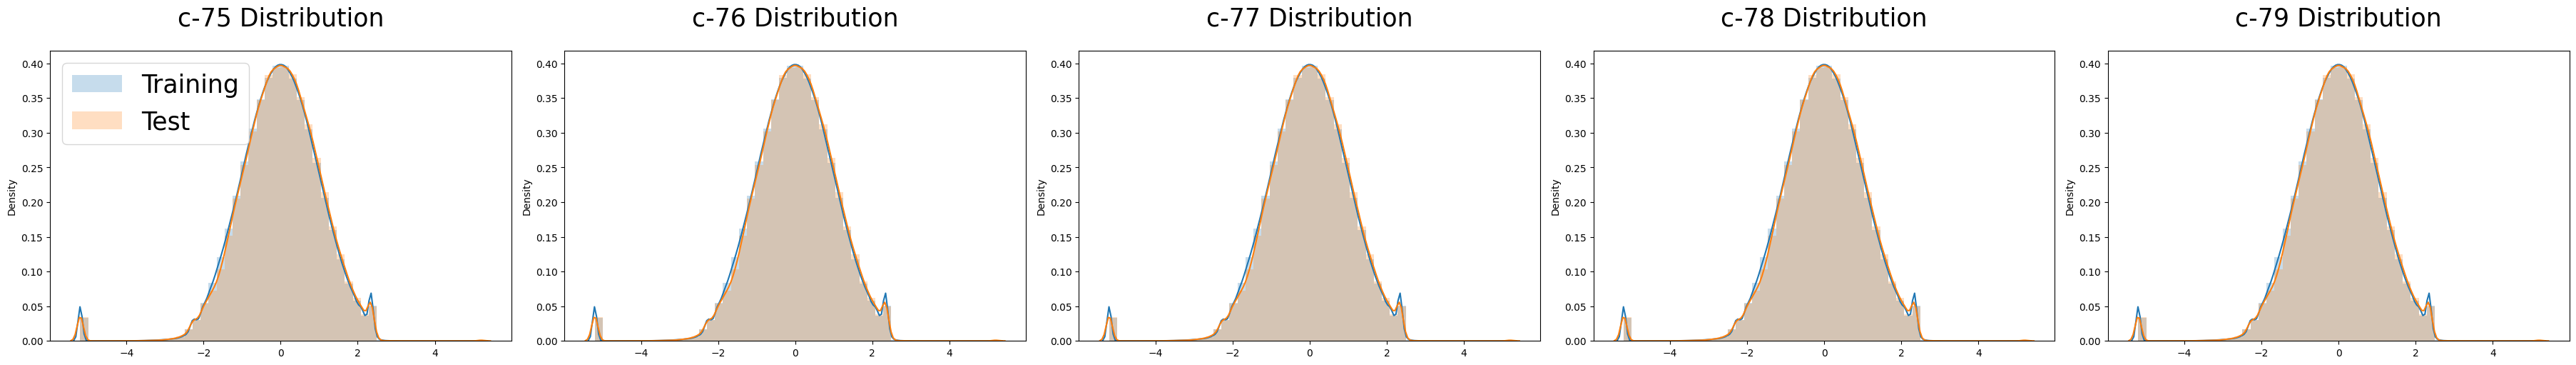

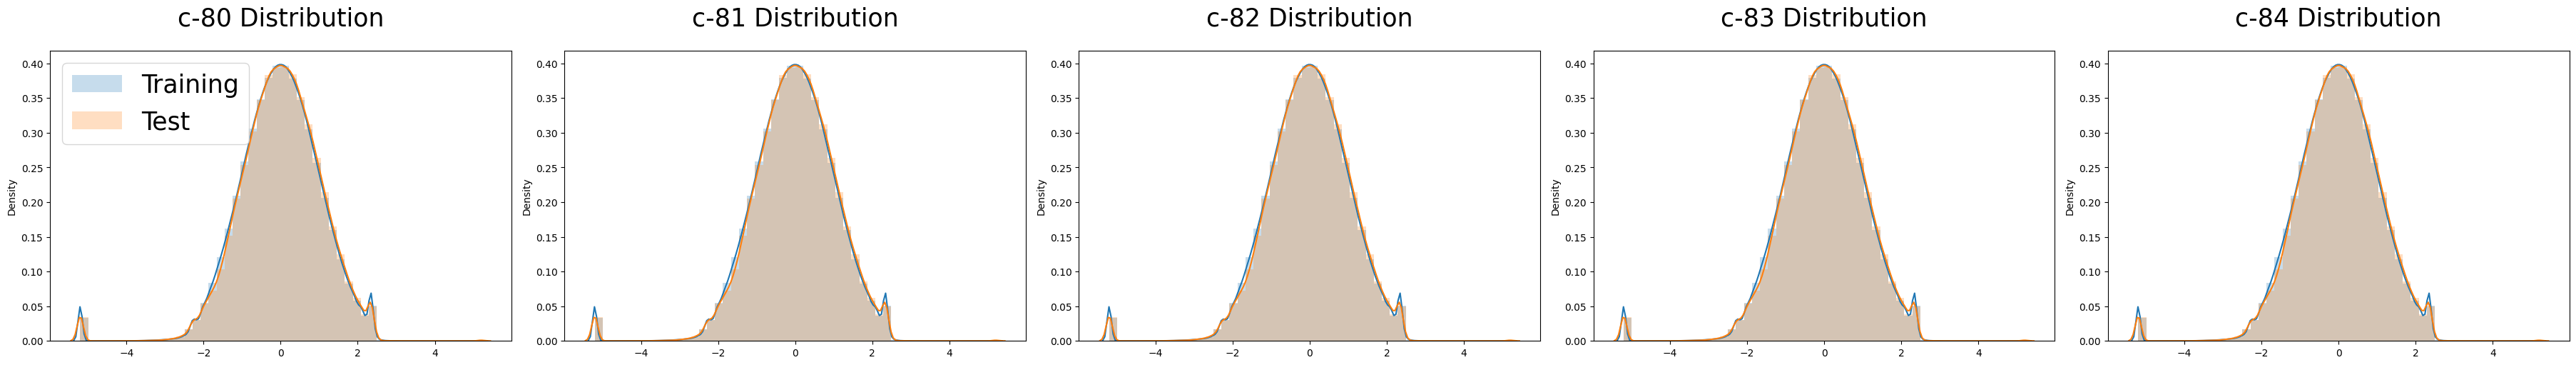

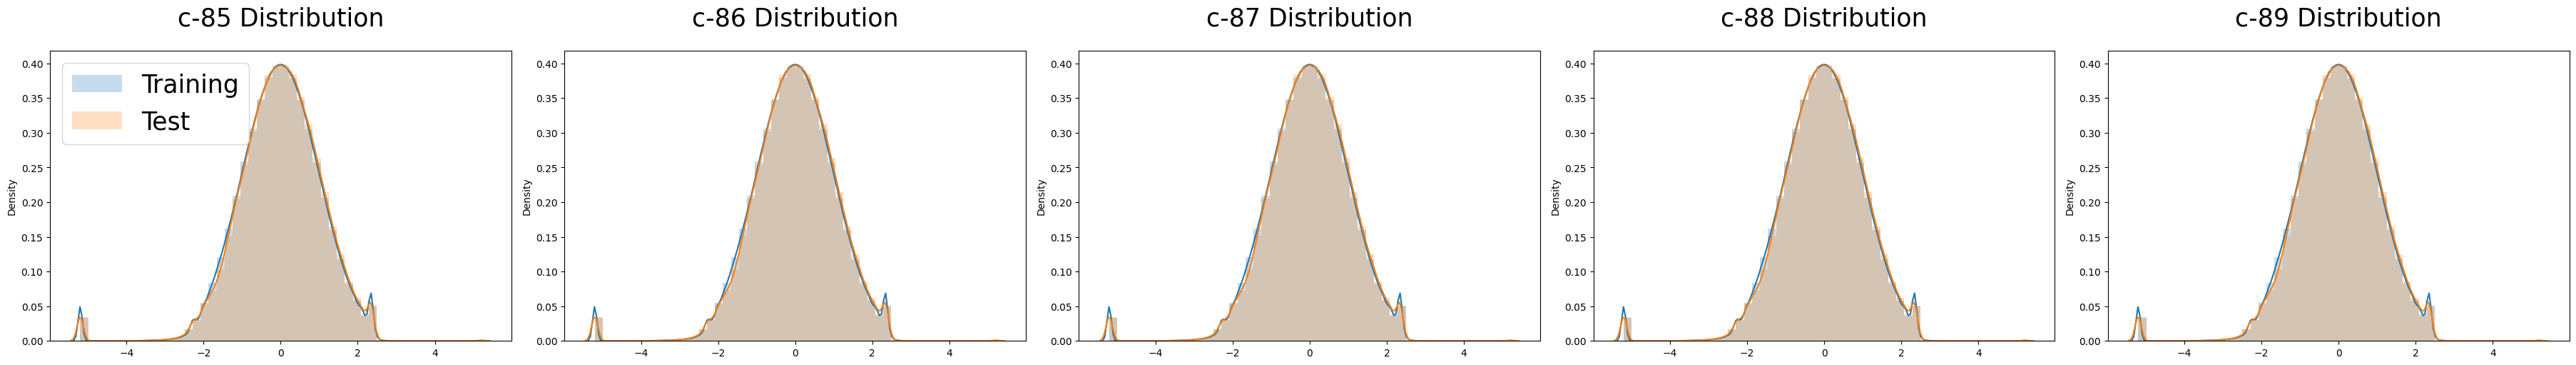

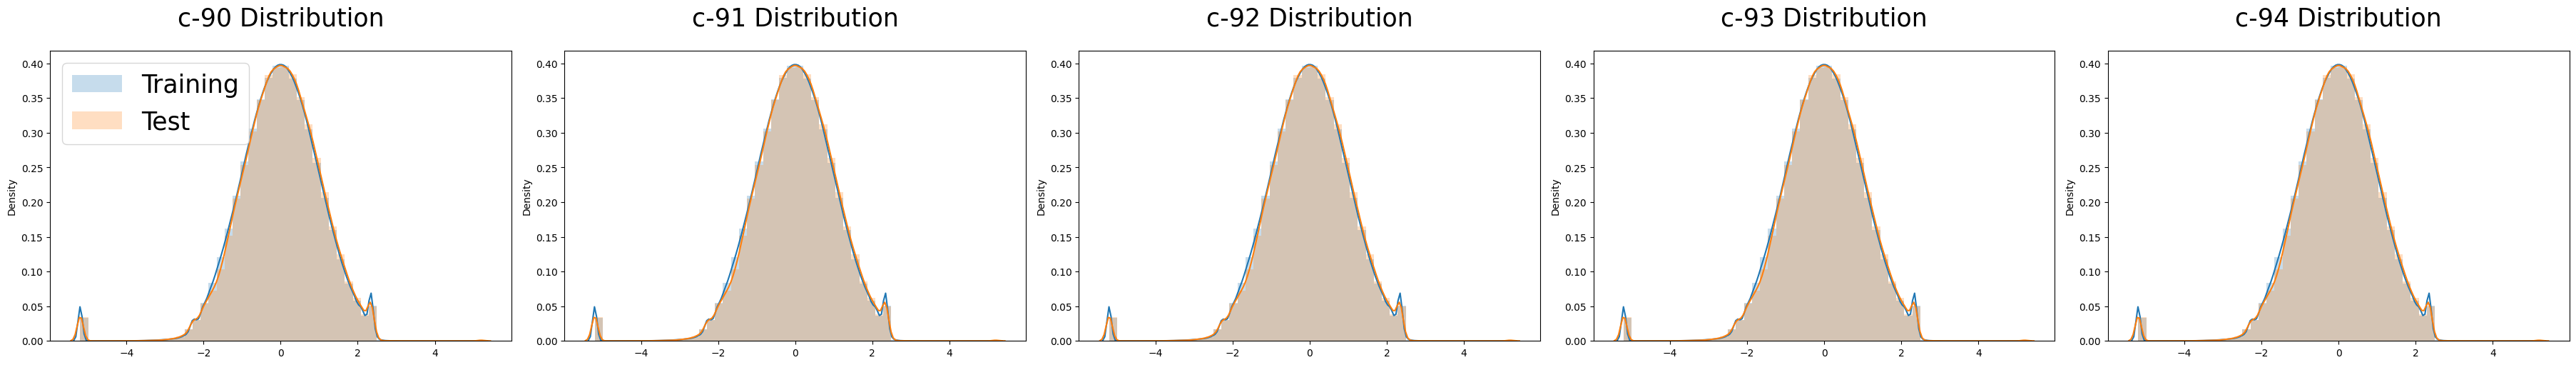

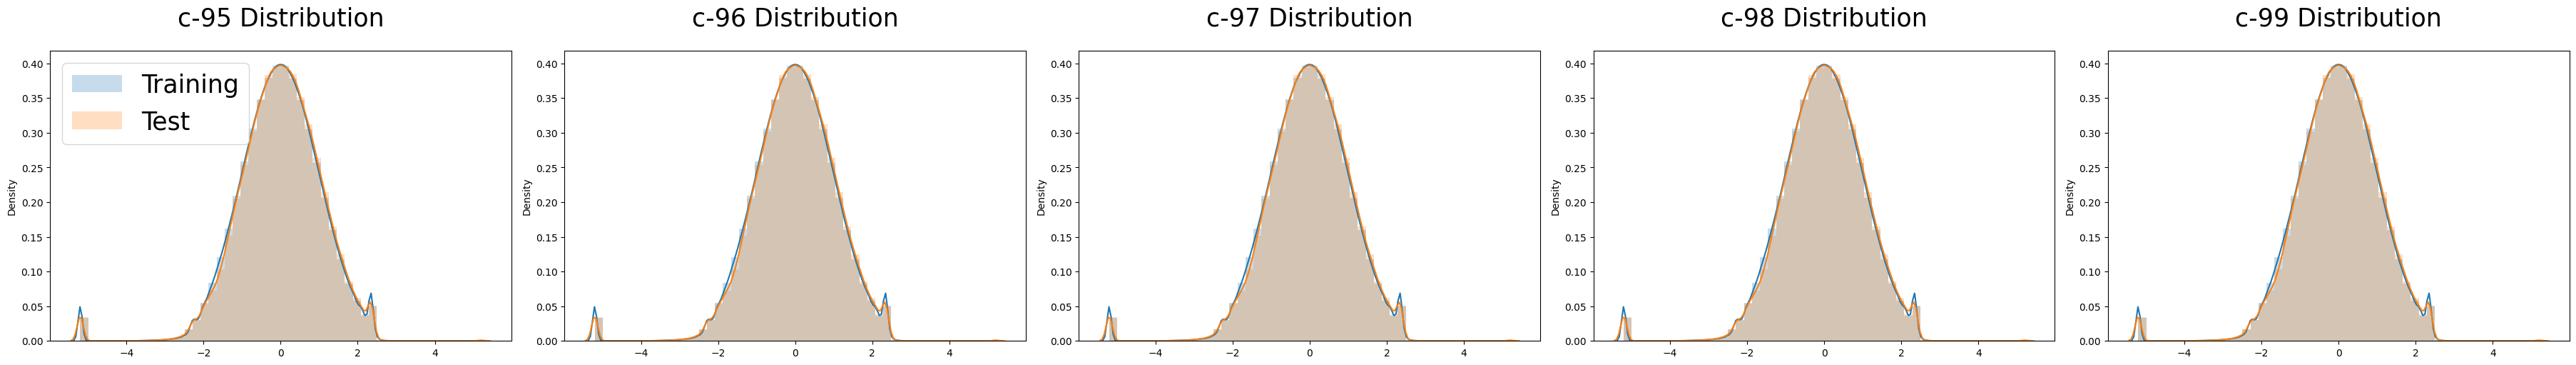

In [8]:
def distplot_cfeature(feature_group):
        
    fig, axes = plt.subplots(ncols=5, figsize=(36, 5), dpi=100, constrained_layout=True)
    title_size = 25
    label_size = 25

    for i, feature in enumerate(feature_group):
        sns.distplot(train_features[CELLS], label='Training', ax=axes[i], hist_kws={'alpha': 0.25})
        sns.distplot(test_features[CELLS], label='Test', ax=axes[i], hist_kws={'alpha': 0.25})
        
        if i % 5 == 0:
            axes[i].legend(prop={'size': 25})
            
        axes[i].set_title(f'{feature} Distribution', size=title_size, pad=title_size)
    
    plt.show()
    
for feature_group in np.array_split(CELLS, len(CELLS) // 5):

    distplot_cfeature(feature_group)

**PCA**

PCA is a technique commonly used to reduce dimension, but here we add more principal components as composite feature and clustering them into some additional features. 

Very creative...

Genes

In [9]:
from sklearn.decomposition import PCA

# decide the n_components for GENES
data=pd.concat([pd.DataFrame(train_features[GENES]),pd.DataFrame(test_features[GENES])])

pca=PCA(random_state=42)
pca.fit(data[GENES])
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

choose:

    components=600

    explained_variance=0.9486

In [9]:
# fit and transform using n_components=600
from sklearn.decomposition import PCA
n_comp=600

data=pd.concat([pd.DataFrame(train_features[GENES]),pd.DataFrame(test_features[GENES])])
data2=(PCA(n_components=n_comp,random_state=42)).fit_transform(data[GENES])

train2=data2[:train_features.shape[0]]
test2=data2[-test_features.shape[0]:]

train_gpca=pd.DataFrame(train2,columns=[f'pca_G-{i}' for i in range(n_comp)])
test_gpca=pd.DataFrame(test2,columns=[f'pca_G-{i}' for i in range(n_comp)])

train_features=pd.concat((train_features,train_gpca),axis=1)
test_features=pd.concat((test_features,test_gpca),axis=1)

Cells

In [11]:
#  do the same for cell features

# decide the n_components for Cells
data=pd.concat([pd.DataFrame(train_features[CELLS]),pd.DataFrame(test_features[CELLS])])

pca=PCA(random_state=42)
pca.fit(data[CELLS])
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

choose:

    components=50

    explained_variance=0.8166

In [10]:
n_comp=50

data=pd.concat([pd.DataFrame(train_features[CELLS]),pd.DataFrame(test_features[CELLS])])
data2=(PCA(n_components=n_comp,random_state=42)).fit_transform(data[CELLS])

train2=data2[:train_features.shape[0]]
test2=data2[-test_features.shape[0]:]

train_cpca=pd.DataFrame(train2,columns=[f'pca_C-{i}' for i in range(n_comp)])
test_cpca=pd.DataFrame(test2,columns=[f'pca_C-{i}' for i in range(n_comp)])

train_features=pd.concat((train_features,train_cpca),axis=1)
test_features=pd.concat((test_features,test_cpca),axis=1)

In [11]:
train_features.shape,test_features.shape

((23814, 1526), (3982, 1526))

**Feature Selection**

Use `VarianceThreshold` to filter out some features that have variance below 0.85

In [12]:
from sklearn.feature_selection import VarianceThreshold

var_thresh=VarianceThreshold(threshold=0.85) # tried some threshold values

data=train_features.append(test_features)
data_transformed=var_thresh.fit_transform(data.iloc[:,4:])

train_features_transformed=data_transformed[:train_features.shape[0]]
test_features_transformed=data_transformed[-test_features.shape[0]:]

train_features=pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1,4),\
                            columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features=pd.concat([train_features,pd.DataFrame(train_features_transformed)],axis=1)

test_features=pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1,4),\
                           columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features=pd.concat([test_features,pd.DataFrame(test_features_transformed)],axis=1)

In [13]:
train_features.shape,test_features.shape

((23814, 1028), (3982, 1028))

In [16]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,0,1,2,3,4,5,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,id_000644bb2,trt_cp,24,D1,1.146806,0.902075,-0.418339,-0.961202,-0.254770,-1.021300,...,0.735146,-0.031558,-0.024911,4.883810,1.547859,1.539458,1.173211,0.926759,-1.048994,-0.216852
1,id_000779bfc,trt_cp,72,D1,0.128824,0.676862,0.274345,0.090495,1.208863,0.688965,...,-1.113667,0.955525,1.285656,5.052956,-0.365251,-0.017749,1.010757,-0.554369,0.675680,-0.275594
2,id_000a6266a,trt_cp,48,D1,0.790372,0.939951,1.428097,-0.121817,-0.002067,1.495091,...,0.511039,1.178801,0.964695,-1.394569,0.293270,0.322476,-0.218039,-0.115235,-0.698979,0.859794
3,id_0015fd391,trt_cp,48,D1,-0.729866,-0.277163,-0.441200,0.766612,2.347817,-0.862761,...,-0.156390,-0.245911,1.206329,-10.982825,1.160133,0.970920,-1.573591,0.005782,-1.252554,-0.382579
4,id_001626bd3,trt_cp,72,D2,-0.444558,-0.481202,0.974729,0.977467,1.468304,-0.874772,...,-1.323957,-0.224108,-0.856281,3.601949,0.564485,0.652861,-0.289594,0.291985,0.277846,0.260670


**K-Means Clustering**


We cluster features together and use `one-hot-encoding` to label data with cluster type.

Cell

In [17]:
train_features2.shape,test_features2.shape

((23814, 876), (3982, 876))

In [14]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [15]:
# determine the number of clusters for each feature type
# cell type

train_cluster_c=train_features2[CELLS].copy()
test_cluster_c=test_features2[CELLS].copy()

data_cluster_c=pd.concat([train_cluster_c,test_cluster_c],axis=0)

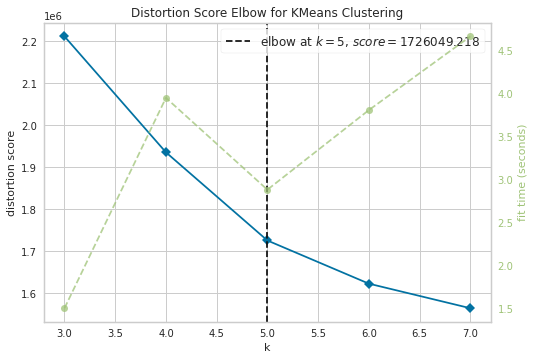

In [20]:
kmeans= KMeans()
visualizer = KElbowVisualizer(kmeans, k=(3,8),random_state=42)
visualizer.fit(data_cluster_c)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

Gene

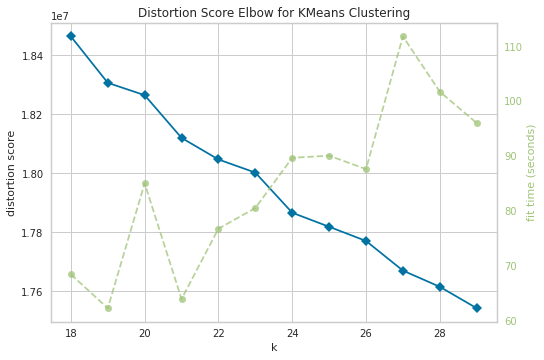

In [21]:
train_cluster_g=train_features2[GENES].copy()
test_cluster_g=test_features2[GENES].copy()

data_cluster_g=pd.concat([train_cluster_g,test_cluster_g],axis=0)

kmeans= KMeans()
visualizer = KElbowVisualizer(kmeans, k=(18,30),random_state=42)
visualizer.fit(data_cluster_g)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

After trying some values, I decided to use `n_clusters_g=22` and `n_clusters_c=4` and not following the elbow rule...

In [16]:
def fe_cluster(train,test,n_clusters_g=22,n_clusters_c=4,SEED=42):
    
    feature_g=GENES
    feature_c=CELLS
    
    def create_cluster(train,test,features,kind='g',n_clusters=n_clusters_g):
        
        train_=train[features].copy()
        test_=test[features].copy()
        data=pd.concat([train_,test_],axis=0)
        
        kmeans=KMeans(n_clusters=n_clusters,random_state=SEED).fit(data)
        
        train[f'clusters_{kind}']=kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}']=kmeans.labels_[train.shape[0]:]
        train=pd.get_dummies(train,columns=[f'clusters_{kind}'])
        test=pd.get_dummies(test,columns=[f'clusters_{kind}'])
        
        return train,test
    
    train,test=create_cluster(train,test,feature_g,kind='g',n_clusters=n_clusters_g)
    train,test=create_cluster(train,test,feature_c,kind='c',n_clusters=n_clusters_c)
    
    return train,test

train_features2,test_features2=fe_cluster(train_features2,test_features2)

In [17]:
train_features2.shape,test_features2.shape

((23814, 902), (3982, 902))

In [24]:
train_features2.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,clusters_g_16,clusters_g_17,clusters_g_18,clusters_g_19,clusters_g_20,clusters_g_21,clusters_c_0,clusters_c_1,clusters_c_2,clusters_c_3
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0,0,0,0,0,0,1,0,0,0
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,1,0,0,1,0,0,0
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,0,0,0,0,1,0,0,0
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,1,0,0,0,0,0,0,0,1
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,0,1,0,0,0


In [18]:
print(train_gpca.shape,train_cpca.shape)
print(test_gpca.shape,test_cpca.shape)

(23814, 600) (23814, 50)
(3982, 600) (3982, 50)


In [19]:
train_pca=pd.concat((train_gpca,train_cpca),axis=1)
test_pca=pd.concat((test_gpca,test_cpca),axis=1)
print(train_pca.shape,test_pca.shape)

(23814, 650) (3982, 650)


pca clustering

In [20]:
data_cluster_pca=pd.concat([train_pca,test_pca],axis=0)
data_cluster_pca.head()

,pca_G-0,pca_G-1,pca_G-2,pca_G-3,pca_G-4,pca_G-5,pca_G-6,pca_G-7,pca_G-8,pca_G-9,...,pca_C-40,pca_C-41,pca_C-42,pca_C-43,pca_C-44,pca_C-45,pca_C-46,pca_C-47,pca_C-48,pca_C-49
0,-5.509135,3.934672,9.358451,-7.911861,4.834325,0.834668,3.446985,1.625308,0.909537,2.112349,...,1.000458,0.067321,0.017445,-0.689324,0.678106,0.034558,0.003029,-0.952844,0.245587,-0.595050
1,-4.899750,3.891428,-11.376574,5.777669,0.924188,0.258293,1.041124,-0.395364,5.401568,1.449645,...,-0.095356,0.709016,-0.517945,-2.041365,-0.414141,-0.754597,-0.057900,0.285719,-0.339816,-1.073094
2,1.258620,-7.242684,-5.448532,-0.802672,0.922407,3.698523,-1.905278,2.625305,-4.668135,0.999668,...,1.339214,0.401715,0.085583,-0.891436,0.331680,-1.607039,-0.386607,-0.465653,0.139421,-0.754917
3,11.514493,-8.717475,-4.263702,-5.765282,-7.029854,-2.680401,-2.229116,6.561454,-2.617044,-3.505768,...,-0.463129,-0.002843,-0.561360,0.078597,0.320905,-0.517472,-0.281094,0.338171,0.064836,0.554733
4,-6.541055,-2.337753,-10.742705,-4.184780,-8.086348,-8.202837,-4.266611,-3.182038,-1.694953,0.846413,...,1.269987,1.596501,-1.739129,0.273182,0.638527,0.411098,-0.442946,1.480799,-0.079082,0.554438


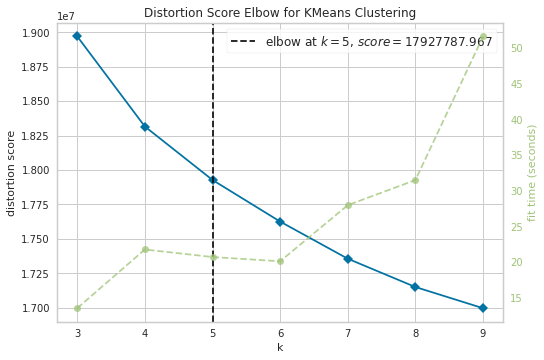

In [28]:
kmeans= KMeans()
visualizer = KElbowVisualizer(kmeans, k=(3,10),random_state=42)
visualizer.fit(data_cluster_pca)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

We choose k=5 for pca clusters.

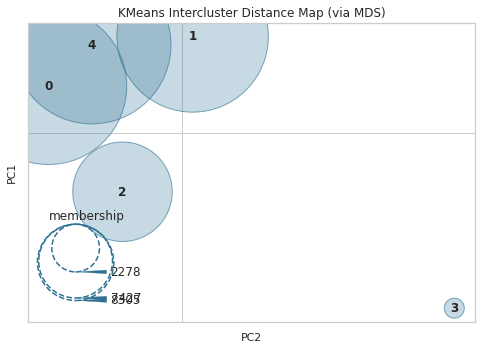

In [29]:
# let's visualize these 5 clusters
from yellowbrick.cluster import InterclusterDistance

visualizer = InterclusterDistance(KMeans(5,random_state=42))
visualizer.fit(data_cluster_pca)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [21]:
def fe_cluster_pca(train,test,n_clusters=5,SEED=42):
    
    data=pd.concat([train,test],axis=0)
    kmeans=KMeans(n_clusters=n_clusters,random_state=SEED).fit(data)
    
    train[f'clusters_pca']=kmeans.labels_[:train.shape[0]]
    test[f'clusters_pca']=kmeans.labels_[train.shape[0]:]
    train=pd.get_dummies(train,columns=[f'clusters_pca'])
    test=pd.get_dummies(test,columns=[f'clusters_pca'])
    return train,test

train_cluster_pca,test_cluster_pca=fe_cluster_pca(train_pca,test_pca)

In [22]:
train_cluster_pca.shape,test_cluster_pca.shape

((23814, 655), (3982, 655))

In [23]:
train_cluster_pca=train_cluster_pca.iloc[:,650:]
test_cluster_pca=test_cluster_pca.iloc[:,650:]

In [24]:
train_cluster_pca.shape,test_cluster_pca.shape

((23814, 5), (3982, 5))

In [25]:
train_features_cluster=train_features2.iloc[:,876:]
test_features_cluster=test_features2.iloc[:,876:]

In [26]:
train_features_cluster.shape,test_features_cluster.shape

((23814, 26), (3982, 26))

**Statistical Features**

1. Squared cell features (100)
2. Squared gene features (45)
   forked from https://www.kaggle.com/vikazrajpurohit/3-model-training-and-inference.
   
   Maybe got them from feature importance of a baseline model or just highly nonstandard features.
3. Combined highly correlated cell features (20)
4. Statistical features (mean,sum,etc) for a given example (15)

In [27]:
gsquarecols=['g-574','g-211','g-216','g-0','g-255',
             'g-577','g-153','g-389','g-60','g-370',
             'g-248','g-167','g-203','g-177','g-301',
             'g-332','g-517','g-6','g-744','g-224',
             'g-162','g-3','g-736','g-486','g-283',
             'g-22','g-359','g-361','g-440','g-335',
             'g-106','g-307','g-745','g-146','g-416',
             'g-298','g-666','g-91','g-17','g-549',
             'g-145','g-157','g-768','g-568','g-396']

                
#for feature in gsquarecols:
#    df[f'{feature}_squared'] = df[feature] ** 2     

In [32]:
len(gsquarecols)

45

In [28]:
train_features2.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,clusters_g_16,clusters_g_17,clusters_g_18,clusters_g_19,clusters_g_20,clusters_g_21,clusters_c_0,clusters_c_1,clusters_c_2,clusters_c_3
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0,0,0,0,0,0,1,0,0,0
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,1,0,0,1,0,0,0
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,0,0,0,0,1,0,0,0
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,1,0,0,0,0,0,0,0,1
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,0,1,0,0,0


In [29]:
def fe_stats(train, test):
    
    features_g = GENES
    features_c = CELLS
    
    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
        df['c52_c42'] = df['c-52'] * df['c-42']
        df['c13_c73'] = df['c-13'] * df['c-73']
        df['c26_c13'] = df['c-23'] * df['c-13']
        df['c33_c6'] = df['c-33'] * df['c-6']
        df['c11_c55'] = df['c-11'] * df['c-55']
        df['c38_c63'] = df['c-38'] * df['c-63']
        df['c38_c94'] = df['c-38'] * df['c-94']
        df['c13_c94'] = df['c-13'] * df['c-94']
        df['c4_c52'] = df['c-4'] * df['c-52']
        df['c4_c42'] = df['c-4'] * df['c-42']
        df['c13_c38'] = df['c-13'] * df['c-38']
        df['c55_c2'] = df['c-55'] * df['c-2']
        df['c55_c4'] = df['c-55'] * df['c-4']
        df['c4_c13'] = df['c-4'] * df['c-13']
        df['c82_c42'] = df['c-82'] * df['c-42']
        df['c66_c42'] = df['c-66'] * df['c-42']
        df['c6_c38'] = df['c-6'] * df['c-38']
        df['c2_c13'] = df['c-2'] * df['c-13']
        df['c62_c42'] = df['c-62'] * df['c-42']
        df['c90_c55'] = df['c-90'] * df['c-55']
        
        
        for feature in features_c:
             df[f'{feature}_squared'] = df[feature] ** 2     
                
        for feature in gsquarecols:
            df[f'{feature}_squared'] = df[feature] ** 2        
        
    return train, test

train_features2,test_features2=fe_stats(train_features2,test_features2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,g-298_squared,g-666_squared,g-91_squared,g-17_squared,g-549_squared,g-145_squared,g-157_squared,g-768_squared,g-568_squared,g-396_squared
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.105820,0.127449,1.261129,0.402210,0.929296,0.030906,0.011903,0.090481,0.011300,0.044184
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.204756,0.025091,0.148533,0.080599,0.081910,0.124186,0.017030,0.026439,0.101761,0.506802
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0.047611,0.013572,0.183698,0.094556,0.888495,5.978025,0.129456,0.336052,0.074693,6.801664
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0.230400,0.026929,24.167056,0.731709,4.981824,2.982529,0.279524,0.039840,3.243601,0.131044
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,1.127844,0.527657,0.644006,2.920681,0.365662,0.172391,0.000000,1.004004,0.091023,1.340964


In [35]:
pd.DataFrame(train_features2[CELLS].skew(axis=1))

,0
0,-0.299268
1,-0.617579
2,-0.655827
3,-0.376320
4,-0.417832
...,...
23809,-0.062658
23810,-0.187653
23811,-0.266126
23812,-0.091236


In [40]:
train_features_stats=train_features2.iloc[:,902:]
test_features_stats=test_features2.iloc[:,902:]

In [42]:
train_features = pd.concat((train_features, train_features_cluster,train_cluster_pca,train_features_stats), axis=1)
test_features = pd.concat((test_features, test_features_cluster,test_cluster_pca,test_features_stats), axis=1)

In [44]:
train_features.shape,test_features.shape

((23814, 1239), (3982, 1239))

In [45]:
train_drug.head()

,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c
3,id_0015fd391,8c7f86626
4,id_001626bd3,7cbed3131


In [48]:
# drop control group
train = train_features.merge(train_targets_scored, on='sig_id')
train = train.merge(train_targets_nonscored, on='sig_id')
train = train.merge(train_drug, on='sig_id')
train = train[train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)

In [52]:
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

In [53]:
train.shape,test.shape

((21948, 1847), (3624, 1238))

In [54]:
train.head()

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor,drug_id
0,id_000644bb2,24,D1,1.146806,0.902075,-0.418339,-0.961202,-0.254770,-1.021300,-1.369236,...,0,0,0,0,0,0,0,0,0,b68db1d53
1,id_000779bfc,72,D1,0.128824,0.676862,0.274345,0.090495,1.208863,0.688965,0.316734,...,0,0,0,0,0,0,0,0,0,df89a8e5a
2,id_000a6266a,48,D1,0.790372,0.939951,1.428097,-0.121817,-0.002067,1.495091,0.238763,...,0,0,0,0,0,0,0,0,0,18bb41b2c
3,id_0015fd391,48,D1,-0.729866,-0.277163,-0.441200,0.766612,2.347817,-0.862761,-2.308829,...,0,0,0,0,0,0,0,0,0,8c7f86626
4,id_001626bd3,72,D2,-0.444558,-0.481202,0.974729,0.977467,1.468304,-0.874772,-0.372682,...,0,0,0,0,0,0,0,0,0,7cbed3131


In [55]:
target_cols = [x for x in train_targets_scored.columns if x != 'sig_id']
aux_target_cols = [x for x in train_targets_nonscored.columns if x != 'sig_id']
all_target_cols = target_cols + aux_target_cols

num_targets = len(target_cols)
num_aux_targets = len(aux_target_cols)
num_all_targets = len(all_target_cols)

print('num_targets: {}'.format(num_targets))
print('num_aux_targets: {}'.format(num_aux_targets))
print('num_all_targets: {}'.format(num_all_targets))

num_targets: 206
num_aux_targets: 402
num_all_targets: 608


In [56]:
print(train.shape)
print(test.shape)
print(sample_submission.shape)

(21948, 1847)
(3624, 1238)
(3982, 207)


In [62]:
train.to_csv('/kaggle/working/train_no_index.csv',index=False)
test.to_csv('/kaggle/working/test_no_index.csv',index=False)